In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
import trimesh
from trimesh import primitives, transformations
from trimesh.exchange.obj import load_obj
import numpy as np
import math
import matplotlib.pyplot as plt
from datasets import SingleModelData
from models import VNEncoder, VNDecoder, VNAutoEncoder

%load_ext autoreload
%autoreload 2

c:\Users\giaco\anaconda3\envs\giatorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
encoder = VNEncoder(576, 64, use_relu=True)
decoder = VNDecoder(64, 576, use_relu=True)

In [3]:
x = torch.randn((32, 576, 3))

In [4]:
z = encoder(x)

In [5]:
z.shape

torch.Size([32, 64, 3])

In [6]:
z[0][0]

tensor([ 0.0274, -0.4424,  0.1343], grad_fn=<SelectBackward0>)

In [7]:
x_ = decoder(z)

In [8]:
x_.shape

torch.Size([32, 576, 3])

In [9]:
dataset = SingleModelData()
loader = DataLoader(dataset, batch_size=64)

In [10]:
data = next(iter(loader))

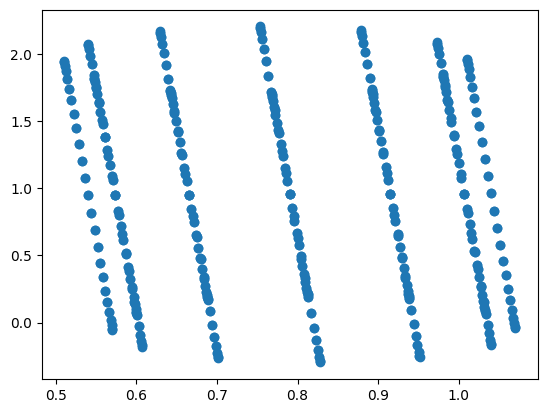

In [11]:
verts = data[13].numpy()
plt.scatter(verts[:,0], verts[:,1])

In [24]:
train_bs = 32
#test_bs = 1000
lr = 1e-4
n_iter = 10000

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = SingleModelData()
n_verts = dataset.num_verts
train_loader = DataLoader(dataset, batch_size=train_bs,
                    shuffle=False)
train_loader = iter(train_loader)
# test_loader = DataLoader(dataset, batch_size=test_bs,
#                     shuffle=False)

model = VNAutoEncoder(n_verts, use_relu=False)
model.to(device)

opt = Adam(model.parameters(), lr=lr)

for i in range(n_iter):
    
    data = next(train_loader)
    data = data.to(device)
    
    opt.zero_grad()
    
    y_pred, _ = model(data)
    loss = F.mse_loss(data, y_pred)
    if i % 200 == 0:
        print(i, '-', loss.item())
    loss.backward()
    opt.step()

0 - 1.2599064111709595
200 - 0.006627663038671017
400 - 3.3285716654063435e-06
600 - 1.051818743214028e-09
800 - 4.603395030618185e-13
1000 - 6.186504352420977e-14
1200 - 4.190042613544907e-14
1400 - 3.543492200510333e-14
1600 - 3.2428249809816206e-14
1800 - 3.16277393001569e-14
2000 - 3.2155464543218854e-14
2200 - 3.155328849222504e-14
2400 - 3.0135507804451844e-14
2600 - 3.1365792667152614e-14
2800 - 3.1887351510358555e-14
3000 - 3.093549654181564e-14
3200 - 2.987454372966637e-14
3400 - 3.083212125280094e-14
3600 - 3.060390008362453e-14
3800 - 3.0797931614917964e-14
4000 - 1.8189002550222239e-13
4200 - 4.644432841788282e-12
4400 - 2.615306788408128e-13
4600 - 1.068053862040598e-13
4800 - 9.69366798744993e-14
5000 - 9.706979279622621e-14
5200 - 3.0768319343081954e-14
5400 - 3.0906802453694454e-14
5600 - 3.31425696348947e-14
5800 - 3.090258422961713e-14
6000 - 3.240562386572915e-14
6200 - 1.5314465144911082e-06
6400 - 2.823422715785874e-14
6600 - 2.888225140822154e-14
6800 - 2.74007890

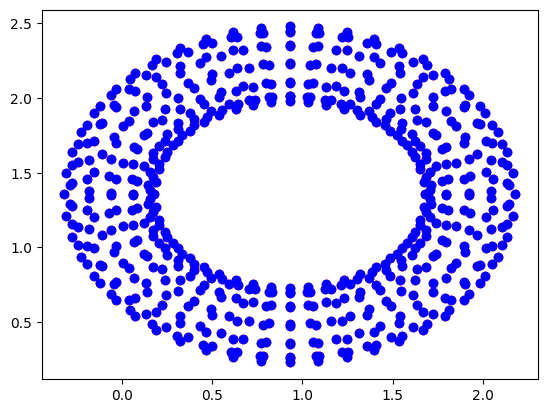

In [13]:
whichsample = 25
verts_pred = y_pred[whichsample].detach().cpu().numpy()
verts_real = data[whichsample].detach().cpu().numpy()
plt.scatter(verts_pred[:,0], verts_pred[:,1], c='red')
plt.scatter(verts_real[:, 0], verts_real[:, 1], c='blue')

#### Test equivariance

In [14]:
with open('data/torus.obj', 'rb') as f:
    obj = load_obj(f)
vertices = obj['vertices']

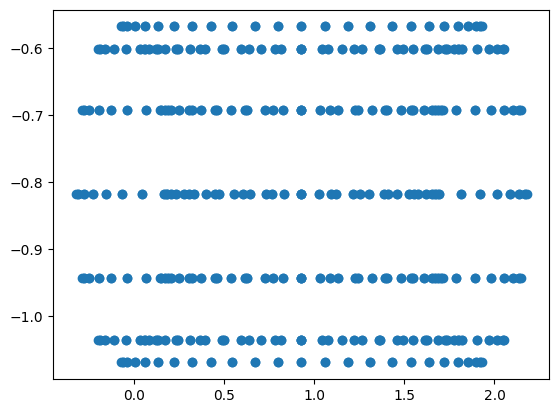

In [15]:
plt.scatter(vertices[:, 0], vertices[:, 1])

In [16]:
angle = math.pi/2
direction = [0, 1, 1]
rot_matrix = transformations.rotation_matrix(angle,
                                             direction,
                                             [0, 0, 0])
transf_vertices = np.column_stack([vertices, 
                            np.ones((len(vertices), 1))])
transf_vertices = transf_vertices @ rot_matrix

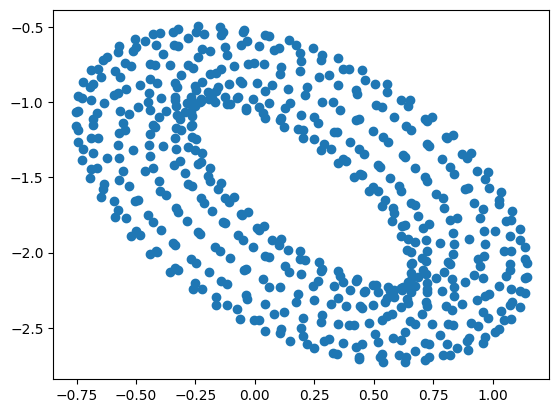

In [23]:
plt.scatter(transf_vertices[:, 0], transf_vertices[:, 1])

In [18]:
in_verts = torch.Tensor(vertices).unsqueeze(0).to(device)
model.eval()
encoder = model.encoder
decoder = model.decoder

In [19]:
z = encoder(in_verts)

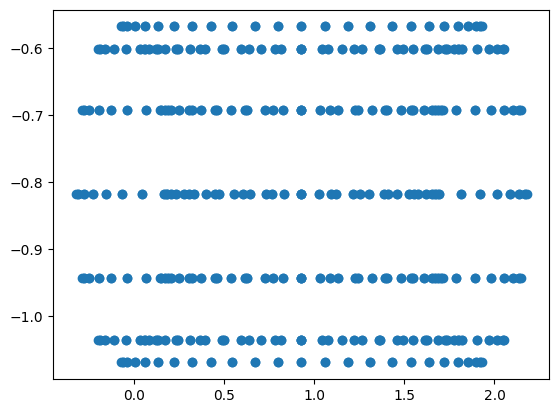

In [20]:
x_pred = decoder(z).detach().cpu().numpy()[0]
plt.scatter(x_pred[:, 0], x_pred[:, 1])

In [21]:
angle = math.pi/2
direction = [0, 1, 1]
rot_matrix = transformations.rotation_matrix(angle,
                                             direction,
                                             [0, 0, 0])
z_transf = z.detach().cpu().numpy()[0]
z_transf = np.column_stack([z_transf, 
                            np.ones((len(z_transf), 1))])
z_transf = z_transf @ rot_matrix
z_transf = torch.Tensor(z_transf[:, :3]).unsqueeze(0).to(device)

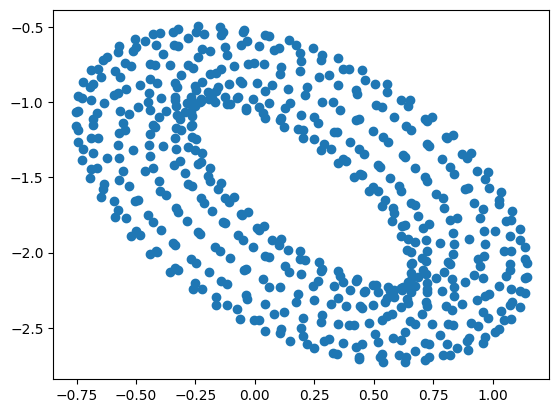

In [22]:
x_tr_pred = decoder(z_transf).detach().cpu().numpy()[0]
plt.scatter(x_tr_pred[:, 0], x_tr_pred[:, 1])